[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/042_cnns/cnns.ipynb)

# Redes Neuronales Convolucionales

En posts anteriores hemos presentado varias arquitecturas diferentes de `redes neuronales`. Algunos ejemplos son el [`Perceptrón Multicapa`](https://sensioai.com/blog/023_mlp_backprop) o las [`redes neuronales recurrentes`](https://sensioai.com/blog/034_rnn_intro), las cuales hemos aplicado para [predicción de series temporales](https://sensioai.com/blog/035_rnn_forecast) y varias aplicaciones de [lenguaje](https://sensioai.com/blog/038_clasificacion_texto). En este post vamos a presentar una nueva arquitectura de `red neuronal` conocida como `red neuronal convolucional`, especialmente diseñada para trabajar con imágenes.

## Introducción

Las `redes neuronales convolucionales` (CNNs) surgieron del estudio del córtex visual del cerebro y se han utilizado en el reconocimiento de imágenes desde la década de los 80. En los últimos años, gracias al aumento de la potencia computacional, la cantidad de datos de entrenamiento disponibles y los trucos ya explicados anteriormente para entrenar redes profundas, las CNNs han logrado lograr un rendimiento sobrehumano en algunas tareas visuales complejas. Este tipo de red se puede encontrar en servicios de búsqueda de imágenes, coches autónomos, sistemas de clasificación de vídeo automático y muchas otras aplicaciones. Además, las CNNs no se limitan a la percepción visual, también tienen éxito en tareas como el reconocimiento de voz y el procesamiento de datos tridimensionales.

### El córtex visual

Las neuronas del córtex visual tienen un pequeño *campo receptivo local*, lo que significa que reaccionan solo a los estímulos visuales ubicados en una región limitada del campo visual. Los campos receptivos de diferentes neuronas pueden superponerse y juntos forman el campo visual completo.

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/visual_cortex.png)

Las neuronas de las primeras capas del córtex visual reaccionan solo ante ciertos patrones simples, como por ejemplo líneas horizontales mientras que otras reaccionan a líneas verticales (dos neuronas pueden tener el mismo campo receptivo pero reaccionan a diferentes orientaciones de línea). En las capas siguientes, las neuronas tienen campos receptivos más grandes y reaccionan a patrones más complejos, que pueden ser combinaciones de patrones de nivel inferior, construyendo de esta manera una jerarquía en diferentes capas que resultan finalmente en las formas y colores que vemos.

Basándose en estos conceptos, Yann LeCunn introdujo las CNNs en 1998 en la famosa arquitectura [LeNet-5](https://colab.research.google.com/drive/1fqxaTs-Ux9KQHyCJsToFTZwSNoHv9rKe#scrollTo=CMK6qB1EdfqC), utilizada por los bancos para reconocer de manera automática los números manuscritos en cheques para un procesamiento más rápido.

## La Capa Convolucional

Como veremos más adelante, las `redes convolucionales` están formadas por varias capas con diferente responsabilidad. De entre estas capas, la más importante es la `capa convolucional` la cual es responsable de identificar y construir las diferentes formas, colores y texturas de manera similar al córtex visual. Para llevar a cabo esta tarea usaremos un conjunto de *filtros* (también llamados *kernels*) los cuales deslizaremos por toda la imagen aplicando la operación *convolución*. Esta operación consiste en aplicar el producto escalar entre el filtro y los píxeles de la imagen cubiertos por el filtro, lo que se conoce como el *campo receptivo* (o *receptive field*). En el siguiente gif puedes ver esta operación en acción, en la que tenemos un filtro de 3x3 el cual deslizamos por nuestra imagen, la cual tiene una resolución de 5x5. Para cada posible posición del filtro dentro de la imagen, calculamos el producto de cada pixel por el valor del filtro correspondiente y guardamos el resultado en el mapa de salida.

![](https://miro.medium.com/max/1052/1*GcI7G-JLAQiEoCON7xFbhg.gif)

En este segundo ejemplo estamos aplicando la misma operación, pero ahora en el caso de que nuestra imagen tenga 3 canales (una imagen en color RGB). En este caso, nuestros filtros también tienen 3 canales. Además estamos aplicando más de un filtro, lo cual resulta en número de canales en el mapa de salida igual al número de filtros utilizados.

![](https://cdn-media-1.freecodecamp.org/images/gb08-2i83P5wPzs3SL-vosNb6Iur5kb5ZH43)

Vamos a ver un ejemplo de aplicación con imágenes reales, en este caso con imágenes del dataset CIFAR10 con el cual ya hemos trabajado anteriormente.

In [1]:
# Importamos bibliotecas
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Vemos si la GPU esta disponible
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Extraer el rar
# !pip install rarfile
# import rarfile
# with rarfile.RarFile('/content/sample_data/food.rar', 'r') as rar:
#     rar.extractall('.')

In [6]:
# Leemos el dataset
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

data = pd.read_csv('/content/drive/MyDrive/02-2023/SIS-421/NuevosCuadernillosApuntes/food/food.csv')
# Lista de Id's de las imagenes
images = data['ImageId'].tolist()
# Lista de las clases
labels = data['ClassName'].tolist()



In [7]:
# Leemos las etiquetas del dataset
# Cambia las etiquetas de texto a numeros
label_to_num = {label: i for i, label in enumerate(set(labels))}
num_to_label = {i: label for label, i in label_to_num.items()}

class_labels = [label_to_num[label] for label in labels]

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

Una vez convertidas todas las imágenes a arrays de `Numpy`, vamos a visualizar un ejemplo aleatorio.

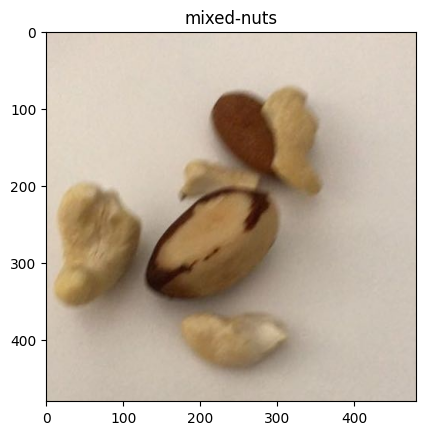

In [10]:
import random
import matplotlib.pyplot as plt

ix = random.randint(0, len(train_images))
img, label = Image.open(f'/content/drive/MyDrive/02-2023/SIS-421/NuevosCuadernillosApuntes/food/train_images/{train_images[ix]}'), train_labels[ix]

# Mostrar la imagen usando la libreria Pillow
plt.imshow(img)
plt.title(label)
plt.show()

Ahora, vamos a aplicar un filtro definido manualmente a esta imagen. En este caso aplicaremos un filtro de 3x3 con valores de 1 en la primera fila, 0 en la central y -1 en la última. Como puedes ver en el resultado, este filtro es útil para identificar líneas horizontales.

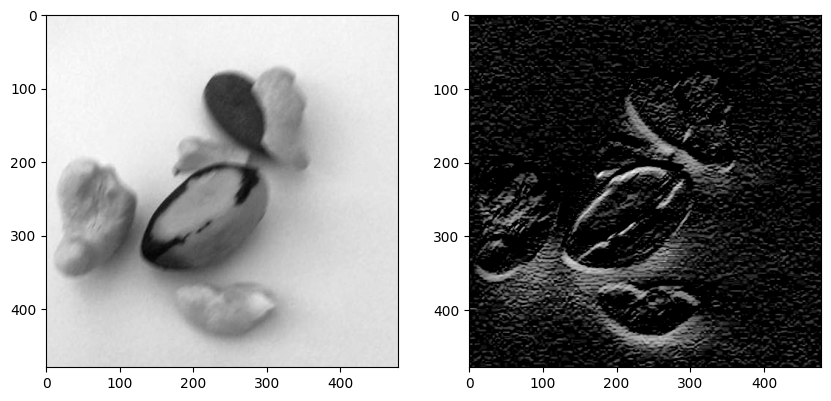

In [11]:
# Aplicamos un filtro manualmente
# En este caso detecta lineas horizontales
import numpy as np
import scipy.signal
from skimage import color
from skimage import exposure
# Convierte la imagen a escala de grises
img = color.rgb2gray(img)
# Filtro o Kernel añadido manualmente
kernel = np.array([[1,1,1],
                   [0,0,0],
                   [-1,-1,-1]])

# Visualizacion de la imagen
edges = scipy.signal.convolve2d(img, kernel, 'valid')
# Mejora la visibilidad
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)
# 1 fila, 2 columnas, tamanio en pulgadas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(edges, cmap=plt.cm.gray)
plt.show()

Si aplicamos ahora el mismo filtro, pero transpuesto, obtenemos un detector de líneas verticales.

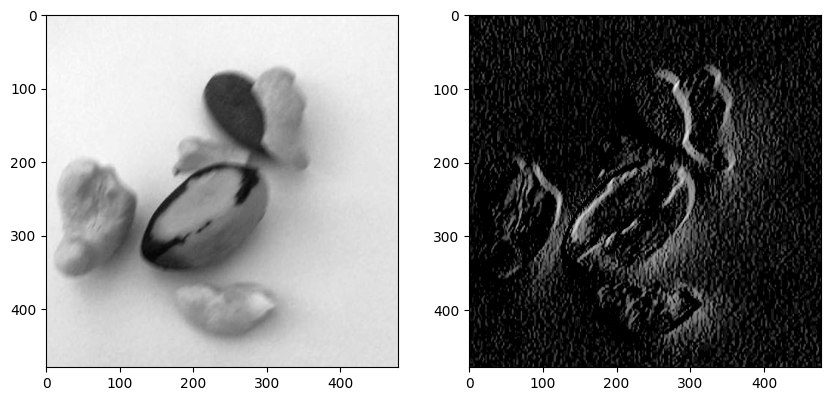

In [12]:
# En este caso detecta lineas horizontales
# La transpuesta detecta lineas verticales
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

edges = scipy.signal.convolve2d(img, kernel, 'valid')
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(edges, cmap=plt.cm.gray)
plt.show()

De la misma manera, el siguiente filtro será útil para detectar bordes en cualquier orientación.

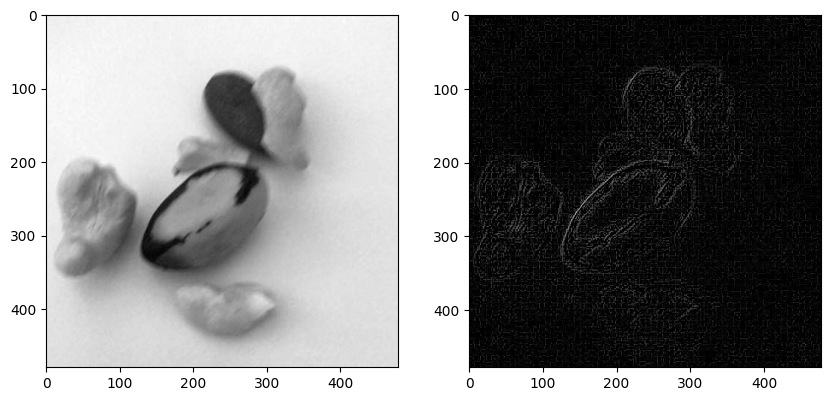

In [13]:
# Detecta los bordes/siluetas en cualquier orientacion
kernel = np.array([[0,-1,0],
                   [-1,4,-1],
                   [0,-1,0]])

edges = scipy.signal.convolve2d(img, kernel, 'valid')
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(edges, cmap=plt.cm.gray)
plt.show()

Como puedes ver, al aplicar varios filtros a nuestra imagen podemos obtener información relevante a la hora de llevar a cabo tareas tales como la clasificación de la imagen, detectar varios objetos en ella o generar una descripción textual de la misma. La pregunta ahora es: ¿Y cómo decidimos que filtros utilizar? La respuesta es fácil, dejaremos que sea la propia red neuronal quién aprenda estos valores a través del proceso de entrenamiento de manera que sea ella misma quien decida qué patrones son los más importantes a la hora de llevar a cabo su tarea. Así pues, los filtros serán ahora los parámetros de nuestra red.

### Implementación en Pytorch

En `Pytorch` tenemos implementada la capa convolucional en el clase `torch.nn.Conv2D`. A esta capa le pasamos como parámetros el número de canales de la imagen a la entrada, el número de filtros, el tamaño del filtro y otros parámetros relevantes de los que hablaremos más adelante. Si miras en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), esta capa espera un tensor a la entrada con dimensiones $(N,C_{in},H,W)$, dónde $N$ es el tamaño del *batch*, $C_{in}$ es el número de canales del mapa de entrada, $H$ es el alto y $W$ el ancho del mapa.

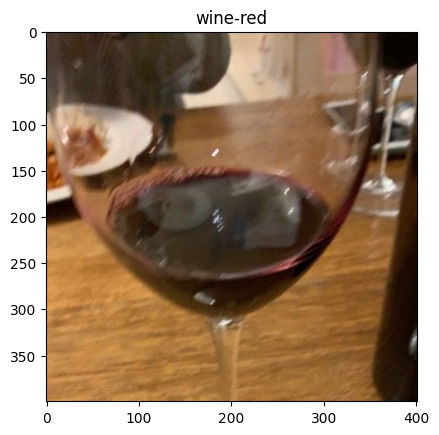

In [14]:
ix = random.randint(0, len(train_images))
img, label = Image.open(f'/content/drive/MyDrive/02-2023/SIS-421/NuevosCuadernillosApuntes/food/train_images/{train_images[ix]}'), train_labels[ix]

plt.imshow(img)
plt.title(label)
plt.show()

In [15]:
#img.shape, img.dtype

In [16]:
# img_tensor = torch.from_numpy(img/255)
# img_tensor.shape, img_tensor.dtype

In [17]:
# img_tensor = img_tensor.unsqueeze(0)
#img_tensor.shape, img_tensor.dtype

In [18]:
# img_tensor = img_tensor.permute(0, 2, 4, 1, 3).float()
# img_tensor.shape, img_tensor.dtype

In [19]:
# convertir la imágen en tensor con dimensiones (N, C_in, H, W)
# N = tamanio del batch / tamanio del lote
# C_in = numero de canales
# H = es el alto
# W = ancho del mapa

# Convertir la imagen a matriz Numpy
# Se divide entre 255 para normalizar los datos
# .unsqueeze(0) -> Agrega una dimension al principio del tensor
img_tensor = torch.from_numpy(np.array(img) / 255.).unsqueeze(0)

# .permute -> cambiar las dimensiones del tensor para que sea comp con la ver
# especifica
# Dimension del batch, numero de canales, alto y ancho
img_tensor = img_tensor.permute(0, 3, 1, 2).float()

img_tensor.shape, img_tensor.dtype

(torch.Size([1, 3, 400, 401]), torch.float32)

In [20]:
# aplicamos 10 filtros de tamaño 3x3
# canales de entreda == kernel_size
# aplicamos 10 filtros(out_channels)
# kernel_size -> tamanio del kernel o filtro 3x3
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')

output.shape
# una imagen, 10 canales, ancho y alto de la imagen

torch.Size([1, 10, 398, 399])

Como puedes ver las dimensiones del tensor de salida son diferentes al tensor de entrada. En primer lugar, el número de canales del mapa de entrada ahora es el número de filtros aplicados (el resultado de aplicar cada filtro se guarda en un canal). En cuanto al ancho y alto, dependerá de la relación entre el tamaño de la imagen y el del filtro. Puedes calcular estas dimensiones de la siguiente manera

$$ o = \lfloor \frac{n+2p-m}{s} \rfloor + 1 $$

donde $o$ es la dimensión de salida, $n$ la de entrada, $m$ es el tamaño del filtro y $p$ y $s$ son dos parámetros con los que podemos jugar para ajustar el tamaño de salida. $p$ es el *padding* y consiste en el número de valores extra que añadimos en los bordes para aumentar el tamaño de la entrada. $s$ es el *stride*, y controla el número de pixeles que el filtro salta en cada paso. $\lfloor \cdot \rfloor$ es el operador *floor*, que redondea cualquier resultado a la baja.

Usar $p = 1$ y $s = 1$ con un filtro de 3x3 no cambiará el tamaño de la imagen.

In [21]:
# Calcula el tamaño de la imagen
# Stride -> Paso o separacion en la que se movera
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, padding = 0, stride = 2)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([1, 10, 199, 200])

In [22]:
img_tensor.shape

torch.Size([1, 3, 400, 401])

Aplicar un salto de 2 pixeles en la aplicación del filtro, $s = 2$, reducirá el tamaño a la mitad.

In [23]:
# s = 2 -> Reduce el tamanio a la mitad
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, padding = 1, stride = 2)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([1, 10, 200, 201])

In [24]:
conv1 = torch.nn.Conv2d(in_channels = 10, out_channels = 64, kernel_size = 3, padding = 0, stride = 1)

output2 = conv1(output)

# dimensiones: (N, #filtros, H', W')
output2.shape

torch.Size([1, 64, 198, 199])

En una `red convolucional` tendremos varias de estas `capas convolucionales` en diferentes capas consecutivas, de manera que las entradas a unas capas serán las salidas de las anteriores. De esta manera, la red será capaz de construir patrones cada vez más elaborados a partir de patrones más sencillos. Puedes ver una animación del funcionamiento de esta capa en el siguiente [vídeo](https://www.youtube.com/watch?v=f0t-OCG79-U). También, en el siguiente gif, puedes ver un ejemplo de aplicación.

![](https://thumbs.gfycat.com/AffectionateMemorableGreyhounddog-size_restricted.gif)


## Capas de *Pooling*

Si bien hemos visto que jugando con los tamaños del filtro, *stride* y *padding* podemos controlar el tamaño de los mapas generados por las capas convolucionales, es también común el uso de capas *pooling* para reducir los mapas de características.

![](https://miro.medium.com/max/1456/1*WvHC5bKyrHa7Wm3ca-pXtg.gif)

Estas capas también aplican un filtro sobre su entrada, pero en este caso es un solo filtro que además no tiene parámetros sino que aplica una función predeterminada en su campo receptivo (mínimo, máximo, promedio, etc). La idea detrás del uso de este tipo de capas es la de reducir la resolución de los mapas de características, reduciendo así el coste computacional para entrenar la `red neuronal`, pero manteniendo las características importantes para el reconocimiento de patrones.

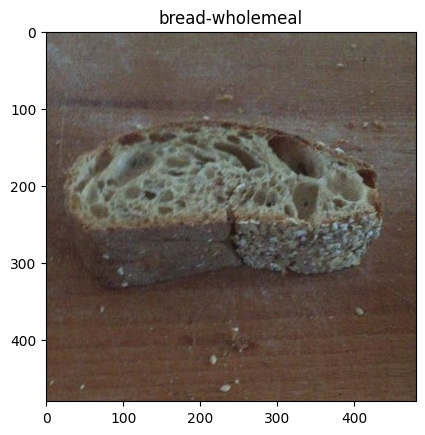

In [27]:
ix = random.randint(0, len(train_images))
img, label = Image.open(f'/content/drive/MyDrive/02-2023/SIS-421/NuevosCuadernillosApuntes/food/train_images/{train_images[ix]}'), train_labels[ix]

plt.imshow(img)
plt.title(label)
plt.show()

In [28]:
# Maxpool kernel de 3 padding1
# Capa MaxPool
pool = torch.nn.MaxPool2d(3, padding=1, stride=2)

# .permute -> cambiar las dimensiones del tensor para que sea comp con la ver
# especifica
# Dimension del batch, numero de canales, alto y ancho
img_tensor = torch.from_numpy(np.array(img) / 255.).unsqueeze(0).permute(0, 3, 1, 2).float()
output = pool(img_tensor)
output.shape

torch.Size([1, 3, 240, 240])

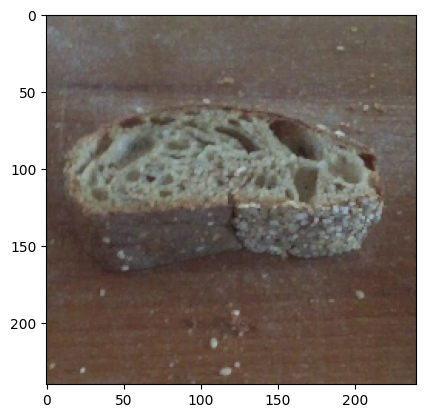

In [29]:
plt.imshow(output.squeeze(0).permute(1,2,0))
plt.show()

## Redes Convolucionales

Una vez hemos visto los comoponentes principales de las `redes convolucionales` vamos a ver un ejemplo de cómo podemos implementar una red convolucional completa para, en este caso, la clasificación de las imágenes en el dataset MNIST. En primer lugar descargamos el dataset.

In [30]:
from torch.utils.data import Dataset, DataLoader

class FoodDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.open(f'/content/drive/MyDrive/02-2023/SIS-421/NuevosCuadernillosApuntes/food/train_images/{train_images[ix]}').resize((40,40))
        image = torch.tensor(np.array(image).astype(np.float32)).permute(2,1,0)
        label = torch.tensor(label_to_num[label])

        return image, label

train = FoodDataset(train_images, train_labels)
test = FoodDataset(test_images, test_labels)

test[0][0].shape, test[0][1],

(torch.Size([3, 40, 40]), tensor(28))

In [31]:
dataloader = {
    'train': DataLoader(train, batch_size=1000, shuffle=True, pin_memory=True),
    'test': DataLoader(test, batch_size=1000, shuffle=False, pin_memory=True)
}

Vamos a definir una `red convolucional` con varias `capas convolucionales` y `capas de pooling`. Para poder clasificar las imágenes, conectaremos las salidas de la última capa de la red convolucional con un `MLP` para obtener las predicciones finales.

In [32]:
# Instala la biblioteca transformers de la cual usaremos FocalNet
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.7 MB/s eta 0:00:00


# FocalNetForImageClassification: Una herramienta poderosa para la clasificación de imágenes

La biblioteca de Transformers de Hugging Face continúa siendo una fuente inagotable de innovación en el campo del procesamiento de lenguaje natural y la visión por computadora. Entre sus numerosos modelos y utilidades, destaca el modelo FocalNetForImageClassification, una poderosa herramienta especializada en la clasificación de imágenes.

## ¿Qué es FocalNetForImageClassification?

FocalNetForImageClassification es una clase implementada en la biblioteca de Transformers de Hugging Face. Su principal enfoque es la clasificación de imágenes, y lo hace de manera excepcional. Este modelo ha sido diseñado meticulosamente para aprovechar las capacidades de las capas convolucionales profundas.

## Capas convolucionales profundas para codificar contextos visuales

La fuerza detrás del éxito de FocalNetForImageClassification radica en su capacidad para codificar contextos visuales en imágenes, abarcando desde rangos cortos hasta largos. Esto se logra mediante el uso de capas convolucionales profundas, que son esenciales para extraer características clave de las imágenes.

## Conclusión

En resumen, FocalNetForImageClassification es una herramienta imprescindible para tareas de clasificación de imágenes. Su incorporación en la biblioteca de Transformers de Hugging Face amplía aún más las capacidades de esta plataforma líder en inteligencia artificial. Si estás buscando una solución efectiva y eficiente para tus proyectos de clasificación de imágenes, definitivamente deberías considerar utilizar FocalNetForImageClassification.


In [33]:
# Hacemos uso del Modelo Focalnet
from transformers import FocalNetForImageClassification, FocalNetConfig
import torch

# 40 tamanio de las imagenes, 61 cantidad de etiquetas
config = FocalNetConfig(image_size=40, num_labels=61)
# Instancia del modelo
model = FocalNetForImageClassification(config=config)
# Contiene 64 imagenes, 3 canales, 40x40
output = model(pixel_values=torch.rand(64,3,40,40))

output.logits.shape

torch.Size([64, 61])

In [34]:
from tqdm import tqdm
import numpy as np

# Entrenamiento del modelo
def fit(model, dataloader, epochs=5):
    model.to(device)
    # Usamos Adam de optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # Diferencia entre las predicciones del modelo y los valores reales
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            y_hat = y_hat.logits
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y_hat = y_hat.logits
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [35]:
fit(model, dataloader)

val_loss 4.18036 val_acc 0.05359: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


Epoch 1/5 loss 4.87954 val_loss 4.18036 acc 0.05644 val_acc 0.05359


val_loss 3.86866 val_acc 0.08039: 100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


Epoch 2/5 loss 4.02389 val_loss 3.86866 acc 0.05581 val_acc 0.08039


val_loss 3.83159 val_acc 0.08039: 100%|██████████| 1/1 [00:05<00:00,  5.93s/it]


Epoch 3/5 loss 3.86117 val_loss 3.83159 acc 0.09133 val_acc 0.08039


val_loss 3.81639 val_acc 0.08039: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


Epoch 4/5 loss 3.81076 val_loss 3.81639 acc 0.08551 val_acc 0.08039


val_loss 3.82558 val_acc 0.08039: 100%|██████████| 1/1 [00:04<00:00,  4.82s/it]

Epoch 5/5 loss 3.80325 val_loss 3.82558 acc 0.09257 val_acc 0.08039


Tras 5 *epochs* nuestra CNN es capaz de clasificar las imágenes en el dataset de test con una precisión cercana al $99 \%$, aunque como puedes observar tenemos *overfitting*. Puedes aplicar varias de las técnicas explicadas en este [post](https://sensioai.com/blog/031_regularization) para reducir este efecto e intentar conseguir un mejor modelo.

¿Cómo decidimos el número de capas?, ¿y el tamaño de los filtros, *padding*, *stride*, ...? Tenemos muchos valores con los que jugar, y llevar a cabo una exploración efectiva puede ser costoso. Es por esto que, a efectos prácticos, los mejor es utilizar configuraciones ya exploradas por otros (en ocasiones incluso podremos usar estas redes ya entrenadas para hacer *transfer learning*) y adaptarlas para nuestro caso concreto.

## Resumen

En este post hemos introducido la arquitectura de `red neuronal` conocida como `red neuronal convolucional`. Este tipo de redes, inspiradas en el funcionamiento del córtex visual, están especialmente diseñadas para trabajar con imágenes. Gracias a la aplicación de la `capa convolucional`, la red será capaz de reconocer diferentes formas, colores y texturas que, de manera jerárquica, irá componiendo en estructuras cada vez más complejas para poder llevar a cabo su tarea de la mejor forma posible. En futuros posts hablaremos sobre diferente arquitecturas de CNN que han aparecido durante los últimos años y que podemos utilizar para nuestras aplicaciones.